In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


먼저 오늘 할 노드에 필요한 라이브러리들을 가져와봤다.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

오늘 노드에 필요한 데이터 셋들을 가져온다.

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


데이터 중에서 max값과 min 값을 출력해보면 위 와 같이 255, 0 이 나왔다.
왜냐하면 픽셀값은 0~255니까 최소, 최대값이 이렇게 나온것이다.

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


이번 프로젝트에선 각 픽셀을 -1,1로 정규화시켜서 사용할 예정이라고 한다.
그래서 중간값 0으로 만들어주기 위해 127.5를 빼고 나눠준다는데 처음에 이해 못했다가 위에 255를 train_x 대신에 넣으면 1이 나오고
0을 넣으면 -1 그 사잇값 아무거나 넣으면 소수점 자리로 나온다는걸 깨달았다.

In [5]:
train_x.shape

(60000, 28, 28)

데이터셋 모양을 확인해보니, 6만장에 크기는 28x28이다.

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

Fashion MNIST의 데이터는 흑백이라고 하니 채널 값에 1을 넣어주면 흑백이미지가 나온다.

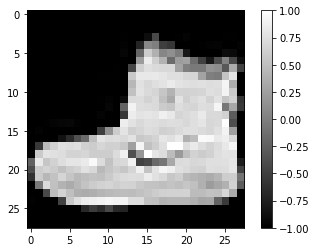

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

여기서 0번 이미지를 꺼내서 출력을 해보니까 나이키신발에 모자이크 낀거같은 사진이 나왔다.

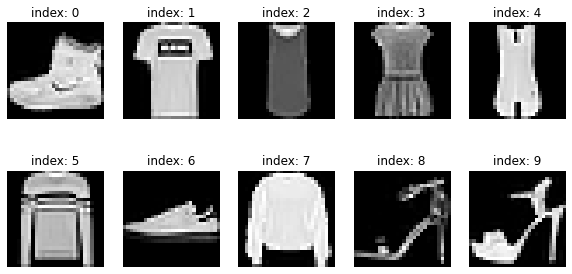

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

위에서는 신발만 출력했지만, 10까지 해보면 구두까지 나왔다. 그 옆에 5라고 써있는 부분이 이미지의 크기를 정해준다.

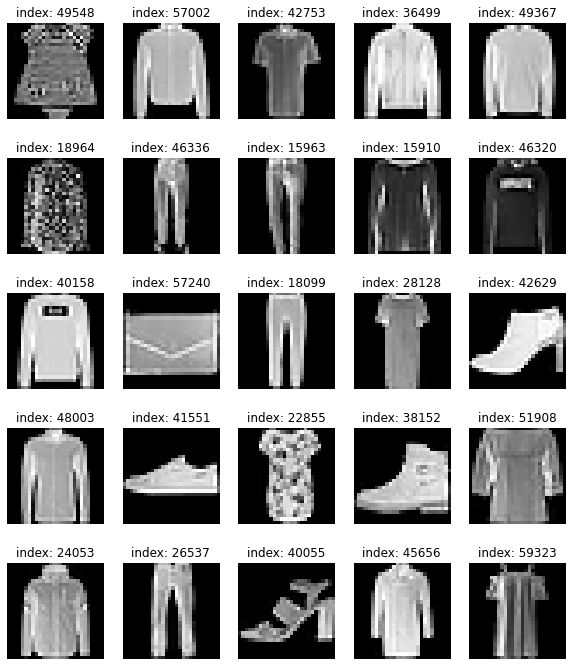

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

어라? 저 위에 10도 이미지 크기였나보다. 여기서는 위와 다르게 5X5로 25개의 이미지가 출력되었다.
랜덤을 사용해서 6만장중 25개의 랜덤 이미지가 출력되었다.

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

BUFFER_SIZE는 전체 데이터를 섞기 위해서 사용한다고 한다.
총 6만개의 데이터가 있고 그걸 다 섞어주기 위해서 6만을 넣어준다.
BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양이기 때문에 적당한 숫자로 넣어준다.

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset 모듈에서 from_tensor_slices를 사용하면 리스트, 넘파이, 텐서플로우의 텐서 자료형 데이터셋을 만들 수 있다고 한다.
train_x라는 넘파이 배열 자료를 섞고 배치 사이즈에 따라 나누도록 만들건데 버퍼 사이즈와 총 데이터 사이즈가 같거나 하면 더 잘 섞인다고 한다.

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

여기서 오늘 배우는 부분이 tf.keras.Sequential()이 부분인데, 이걸로 모델을 시작한 후 레이어를 차곡차곡 쌓아준다고 한다.
저기 dense layer 부터 시작해서 마지막 Conv2DTranspose layer 층까지 쌓아줬다.
여기서 가장 중요한게 Conv2DTranspose layer이 부분이라고 한다.
Conv2DTranspose층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이라고 한다.
아 그래서 저기 위에 7x7x256이 곱하기 2가 되서 14x14x128(끝 거는 나누기 2가 되네) 마지막에 28x28x64가 나오는 것이라고 한다.

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

generator라는 변수를 생성하고, 그 내용들을 불러와봤다.

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

아 여기서 맨앞에 1은 1개라는 뜻이라고 한다.
1개 이미지에 크기는 28x28 거기에 색은 흑백

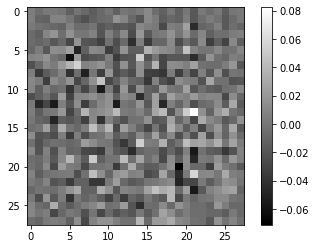

In [16]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

이미지를 출력해보면, 이상한 그림만 나왔다.
그런데 궁금해서 저 가운데 빈 칸에 아무 숫자를 넣어봤는데 처음에 2를 넣으니까 두줄에 검은색,흰색,회색이 가로로 패턴처럼 출력되었고
28을 넣으니까 위에 그림과 같이 나왔다.
가운데 빈칸 부분은 이미지의 크기인가보다.

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

이미지를 판별하기 위해 판별자를 설계해야 된다.
판별자를 구현하기 위해 make_discriminator_model를 사용한다.
아까는 Conv2DTranspose를 이용해서 이미지의 크기를 점점 늘여갔지만, 이번에는 반대로 Conv2D로 이미지를 줄여나갈 것이다.
그래서 아까 늘린 28x28x1이 결국엔 7x7x128까지 줄어들게 되었다.

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00117871]], dtype=float32)>

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy를 활용해 계산할 loss들은 Fake Image를 구분자에 입력시켜서 판별시키거나, Real Image를 구분자에 입력시켜서 판별시킬 수 있다고 한다.

In [21]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

tf.ones_like(), tf.zeros_like() 함수를 활용해 위에 fake와 real을 0과 1에 비교할 수 있다고 한다.

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_loss는 fake가 1에 가까워지기를 바라므로 tf.ones_like와의 교차 엔트로피값을 계산해주면 된다.

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator_loss는 real이 1에 가까워지고 fake는 0에 가까워지는 것을 바라기 때문에 두개의 loss값을 계산해야한다.
여기서 나온 최종discriminator_loss 값은 이 둘을 더한 값이라고 한다.

In [24]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

discriminator_accuracy는 무조건 1에 가까운게 좋은것이 아니라고 한다.
판별할 때 fake랑 real의 차이가 많이 나서 판별이 쉬운것이고 점점 세세한 부분으로 갈수록 정확도가 낮아질 수 있다.
그래서 여기서 가장 이상적인 것은 처음에는 높게 나왔다가 점점 줄어들어 0.5까지만 가는거라고 한다.
1에 계속 가까우면 생성자가 판별자를 잘 못속이는것이라고 한다.

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

생성자와 구분자는 따로 학습하기 때문에 나눠줘야 한다.

In [26]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

100차원의 노이즈 16개 생성하도록 만들었다.

In [27]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [28]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

@tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환된다고 한다.
그래서 나중에 tensorflow모델 구현을 할 때 유용하게 사용된다고 한다.

In [29]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

images한 세트를 입력으로 받고, 제너레이터가 fake를 생성하기 위한 노이즈를 이미지 한세트와 같은 크기의 batch 사이즈를 생성
그 다음 tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열고, 제너레이터가 노이즈를 입력받아 generated_images생성한다고 한다.
discriminator가 real의 이미지와 fake 이미지인 generated_images를 각 입력받고 real과 fake의 output출력해준다.
출력된 real, fake의 output으로 제너레이터와 discriminator의 각각 손실을 계산하고 다시 real, fake output으로 discriminator의 정확도 계산
gen_tape와 disc_tape을 이용해서 gradient를 자동으로 계산한다.
계산된 gradient를 optimizer에 입력해 가중치 갱신으로 모델을 학습시킨다.
마지막으로 loss와 accuracy를 리턴해준다.

In [30]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

subplot을 이용해서 총 16개의 sample을 시각화하는데 여기서 16개니까 4x4로 나눠서 plt.subplot(4, 4, i+1)이렇게 시각화한다
savefig를 이용해서 파일을 저장한다.

In [31]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

그리고 나중에 이미지를 출력하면서 그래프도 나오게 할건데 그래프에서 볼 부분은 accuracy부분과 loss부분이니까 fake와 real의 accuracy와 gen과 disc의 loss의 값들을 history의 dict 구조에 리스트로 저장했다가 epoch마다 함수로 시각화 할 수 있게 했다.

In [32]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

게임의 chekpoint처럼 저장하는 방법이라고 해야되나? 뭔가 일이 닥쳤을 때 불러올 수 있도록 하자.

In [33]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

지금까지 샘플 이미지 생성하고, 학습 그래프 이미지로 볼 수 있게 시각화 한거 체크포인트한것을 한곳에다 합쳤다.

In [34]:
save_every = 5
EPOCHS = 70

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

횟수를 정했으니 이제 돌려보자.

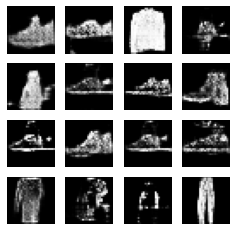

Time for training : 1047 sec


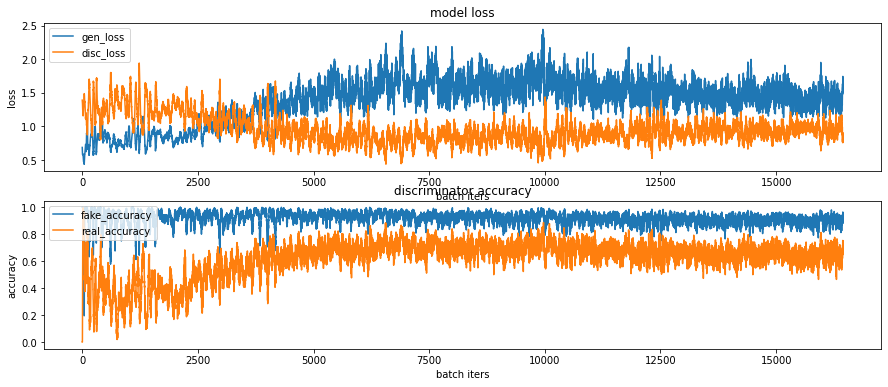

CPU times: user 8min 59s, sys: 1min 48s, total: 10min 48s
Wall time: 17min 28s


In [35]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

이렇게 70번정도 돌리니까 이미지와 accuracy, loss 그래프를 한눈에 볼 수 있다.
이게 돌리면서 이미지가 점점 완성되어가는 모습을 볼 수 있었다.

In [36]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

여기는 위에 예시와 다르게 5만개에 32x32x3으로 컬러이미지다.

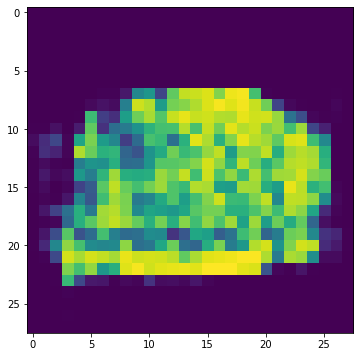

In [37]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

그래서 이미지를 가져와서 출력해보면 색은 있는데 모양이 뭔지 모르겠다.

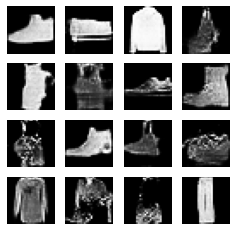

Time for training : 1030 sec


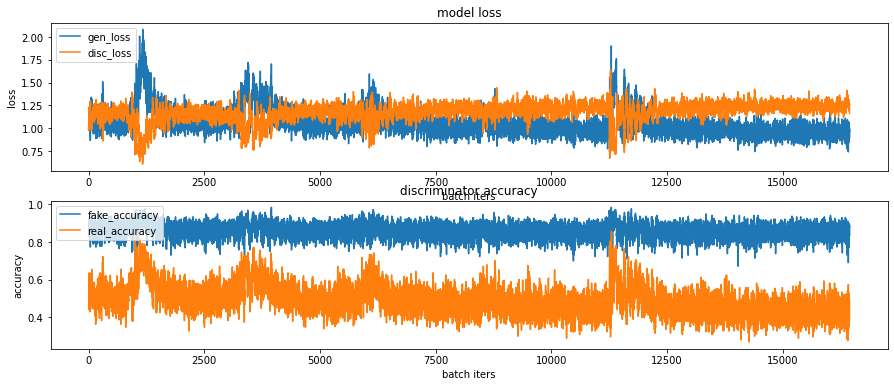

CPU times: user 8min 57s, sys: 1min 49s, total: 10min 46s
Wall time: 17min 11s


In [39]:
%%time
train(train_dataset, EPOCHS, save_every)

위에꺼랑 이미지랑 같게 나와서 뭔가 싶었다
다른분들 결과를 보고싶은데 이게 맞는결과인가 싶다.
그래프는 확실히 다르게 나오긴 했는데 이미지가 위랑 같아서 잘못한거같다.